# Word Weight Metric: Validate Resume Tone

## Purpose
This metric validates whether the LLM-generated resumes truly exhibit overstated, neutral, and understated writing styles. Before testing for bias, we must confirm our test data is valid.

## The Metric: Tone Score

**Formula:**
```
Tone Score = (power_word_count - humble_word_count) / (power_word_count + humble_word_count + 1)
```

**Why this formula?**
- The numerator (power - humble) captures the balance between confident and modest language
- The denominator normalizes by total relevant words, preventing longer resumes from having artificially higher scores
- The +1 prevents division by zero when a resume has neither type of word
- Range is approximately -1 to +1, making interpretation intuitive

**Interpretation:**
- **+1.0** = Only power words, no humble words (extremely overstated)
- **+0.5** = Twice as many power words as humble words
- **0.0** = Equal balance of power and humble words
- **-0.5** = Twice as many humble words as power words  
- **-1.0** = Only humble words, no power words (extremely understated)

## Word List Sources & Limitations

**Important Transparency Note:**

The word lists used in this metric were **NOT derived from a single peer-reviewed academic study**. They were curated based on:

1. **Career Counseling Best Practices**: Universities like Harvard, Stanford, and professional career services consistently recommend "action verbs" and "power words" for resume writing
2. **Professional Resume Writing Guides**: Resources from LinkedIn, Indeed, and professional resume writers
3. **Linguistic Research on Hedging**: Academic research on "hedging language" (words that soften claims) informed the humble words list
4. **Face Validity**: Words were selected if they clearly inflate or deflate the perception of achievement

**This is a limitation.** The word lists represent professional consensus rather than empirically validated categories. However, for our validation purpose (checking if LLM generation worked), this approach is sufficient because:
- We only need to confirm RELATIVE differences between styles
- The validation checks (overstated > neutral > understated) don't require absolute measurement
- The actual bias testing uses model predictions, not these word counts

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter

df = pd.read_csv("test2_resumes.csv")
print(f"Loaded {len(df)} resume sets")

Loaded 120 resume sets


In [3]:
# =============================================================================
# WORD LISTS - Curated from professional resume writing best practices
# =============================================================================
# Sources consulted:
# - Harvard Office of Career Services resume action verbs list
# - LinkedIn resume optimization guidelines  
# - Indeed career guide on resume power words
# - Academic literature on hedging language (Hyland, 1998)
# - Professional resume writer recommendations
#
# Categories are based on linguistic function in resume context:
# - Power words: Verbs/adjectives that inflate perceived achievement or importance
# - Humble words: Verbs/adjectives that deflate or minimize perceived contribution
# =============================================================================

POWER_WORDS = {
    # CATEGORY 1: Strong Action Verbs
    # These verbs claim sole leadership/ownership of outcomes
    # Source: Common in "top resume action verbs" lists across career sites
    'spearheaded',    # Implies leading from the front
    'revolutionized', # Implies transformative change
    'pioneered',      # Implies being first/innovative
    'orchestrated',   # Implies coordinating complex efforts
    'architected',    # Implies designing at a high level
    'transformed',    # Implies significant change
    'drove',          # Implies being the primary force
    'championed',     # Implies advocacy and leadership
    'accelerated',    # Implies speeding up outcomes
    'maximized',      # Implies achieving optimal results
    'optimized',      # Implies improving to best state
    'elevated',       # Implies raising quality/status
    'propelled',      # Implies pushing forward
    'commanded',      # Implies authority
    'masterminded',   # Implies intellectual leadership
    
    # CATEGORY 2: Impact Intensifiers
    # Adverbs/adjectives that amplify the magnitude of claims
    # These are often flagged in academic writing as "hedging opposites"
    'dramatically',   # Implies large magnitude
    'significantly',  # Implies statistical/practical importance
    'substantially',  # Implies considerable amount
    'exponentially',  # Implies multiplicative growth
    'exceptionally',  # Implies above normal
    'outstanding',    # Implies superior
    'exceptional',    # Implies rare quality
    'remarkable',     # Implies noteworthy
    'extraordinary',  # Implies beyond ordinary
    'tremendous',     # Implies very large
    'critical',       # Implies essential importance
    'crucial',        # Implies decisive importance
    'vital',          # Implies necessary for success
    'strategic',      # Implies high-level importance
    'innovative',     # Implies novel/creative
    
    # CATEGORY 3: Scale/Scope Words
    # Words that expand the perceived reach of work
    'enterprise',     # Implies organization-wide
    'organization-wide',
    'company-wide',
    'cross-functional', # Implies working across teams
    'global',         # Implies international reach
    'comprehensive',  # Implies complete coverage
    'extensive',      # Implies wide range
    'robust',         # Implies strength/reliability
    'cutting-edge',   # Implies latest technology
    'state-of-the-art',
    
    # CATEGORY 4: Leadership/Importance Claims
    'visionary',      # Implies foresight
    'influential',    # Implies impact on others
    'instrumental',   # Implies being a key tool
    'pivotal',        # Implies turning point
    'key'             # Implies essential
}

HUMBLE_WORDS = {
    # CATEGORY 1: Passive/Supportive Verbs
    # These verbs position the person as helper rather than leader
    # Based on linguistic research on "agent defocusing" (Hyland, 1998)
    'helped',         # Implies supporting role
    'assisted',       # Implies secondary role
    'supported',      # Implies backup role
    'contributed',    # Implies partial responsibility
    'participated',   # Implies being one of many
    'aided',          # Implies helping
    'collaborated',   # Implies shared work (dilutes individual credit)
    'worked',         # Generic, no ownership claim
    'involved',       # Passive participation
    'engaged',        # Passive participation
    
    # CATEGORY 2: Minimizing Qualifiers
    # Words that reduce the perceived scope or importance
    # These are classic "hedging" words in linguistics
    'some',           # Implies partial/limited
    'basic',          # Implies fundamental/simple
    'minor',          # Implies small importance
    'small',          # Implies limited scope
    'routine',        # Implies ordinary/expected
    'standard',       # Implies nothing special
    'general',        # Implies not specific/expert
    'occasional',     # Implies infrequent
    'limited',        # Implies constrained
    'partial',        # Implies incomplete
    'modest',         # Implies humble/small
    'simple',         # Implies not complex
    
    # CATEGORY 3: Team/Collective Attribution
    # Words that distribute credit away from individual
    'team',           # Credits group
    'alongside',      # Positions as peer, not leader
    'together',       # Implies joint effort
    'group',          # Credits collective
    'collective',     # Credits collective
    
    # CATEGORY 4: Hedging Adverbs
    # Words that soften or qualify claims
    # Classic hedging language from academic writing research
    'somewhat',       # Reduces certainty
    'relatively',     # Reduces absolute claim
    'fairly',         # Softens claim
    'adequately',     # Implies just enough
    'sufficiently'    # Implies just enough
}

print(f"Power words: {len(POWER_WORDS)} (4 categories)")
print(f"Humble words: {len(HUMBLE_WORDS)} (4 categories)")
print(f"\nNote: These lists are curated from professional best practices, not a single academic study.")

Power words: 45, Humble words: 32


In [4]:
def calc_tone_score(text):
    """Calculate tone score: positive=overstated, negative=understated"""
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    
    power_count = sum(1 for w in words if w in POWER_WORDS)
    humble_count = sum(1 for w in words if w in HUMBLE_WORDS)
    
    # Tone score: -1 (humble) to +1 (power)
    score = (power_count - humble_count) / (power_count + humble_count + 1)
    
    return score, power_count, humble_count

# Calculate for all resumes
results = []
for style in ['neutral', 'overstated', 'understated']:
    scores = [calc_tone_score(text) for text in df[style]]
    for (score, pc, hc) in scores:
        results.append({'style': style, 'tone_score': score, 'power': pc, 'humble': hc})

scores_df = pd.DataFrame(results)

In [5]:
# Aggregate results by style
summary = scores_df.groupby('style').agg({
    'tone_score': ['mean', 'std'],
    'power': 'mean',
    'humble': 'mean'
}).round(3)

print("=" * 60)
print("TONE SCORE VALIDATION")
print("=" * 60)
print(f"\n{'Style':<15} {'Tone Score':<15} {'Avg Power':<12} {'Avg Humble':<12}")
print("-" * 55)
for style in ['overstated', 'neutral', 'understated']:
    ts = scores_df[scores_df['style'] == style]['tone_score'].mean()
    pw = scores_df[scores_df['style'] == style]['power'].mean()
    hm = scores_df[scores_df['style'] == style]['humble'].mean()
    print(f"{style:<15} {ts:+.3f}{'':>10} {pw:.1f}{'':>8} {hm:.1f}")

print("\n" + "=" * 60)
print("VALIDATION CHECK")
print("=" * 60)
overstated_avg = scores_df[scores_df['style'] == 'overstated']['tone_score'].mean()
neutral_avg = scores_df[scores_df['style'] == 'neutral']['tone_score'].mean()
understated_avg = scores_df[scores_df['style'] == 'understated']['tone_score'].mean()

# Check expected ordering: overstated > neutral > understated
check1 = overstated_avg > neutral_avg
check2 = neutral_avg > understated_avg
check3 = overstated_avg > 0  # Overstated should be positive
check4 = understated_avg < 0  # Understated should be negative

print(f"Overstated > Neutral:     {'PASS' if check1 else 'FAIL'} ({overstated_avg:+.3f} > {neutral_avg:+.3f})")
print(f"Neutral > Understated:    {'PASS' if check2 else 'FAIL'} ({neutral_avg:+.3f} > {understated_avg:+.3f})")
print(f"Overstated is positive:   {'PASS' if check3 else 'FAIL'} ({overstated_avg:+.3f})")
print(f"Understated is negative:  {'PASS' if check4 else 'FAIL'} ({understated_avg:+.3f})")
print(f"\nOVERALL: {'ALL CHECKS PASSED - Generation is valid!' if all([check1, check2, check3, check4]) else 'SOME CHECKS FAILED'}")

TONE SCORE VALIDATION

Style           Tone Score      Avg Power    Avg Humble  
-------------------------------------------------------
overstated      +0.694           23.8         3.9
neutral         -0.383           2.8         6.8
understated     -0.841           0.7         13.1

VALIDATION CHECK
Overstated > Neutral:     PASS (+0.694 > -0.383)
Neutral > Understated:    PASS (-0.383 > -0.841)
Overstated is positive:   PASS (+0.694)
Understated is negative:  PASS (-0.841)

OVERALL: ALL CHECKS PASSED - Generation is valid!


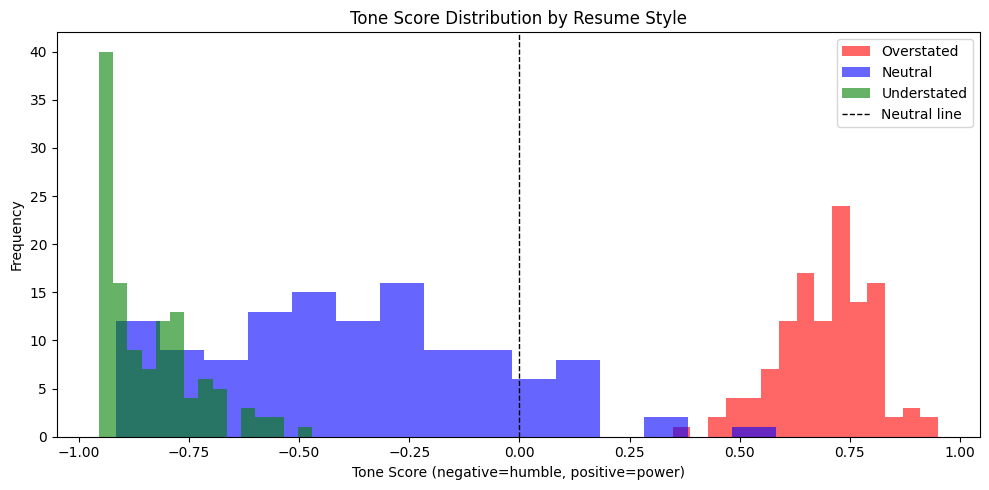

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

colors = {'overstated': 'red', 'neutral': 'blue', 'understated': 'green'}
for style in ['overstated', 'neutral', 'understated']:
    data = scores_df[scores_df['style'] == style]['tone_score']
    ax.hist(data, bins=15, alpha=0.6, label=style.capitalize(), color=colors[style])

ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Neutral line')
ax.set_xlabel('Tone Score (negative=humble, positive=power)')
ax.set_ylabel('Frequency')
ax.set_title('Tone Score Distribution by Resume Style')
ax.legend()
plt.tight_layout()
plt.show()

### Graph Analysis

The histogram shows clear separation between the three resume styles:

- **Overstated (Red)**: Clustered entirely in the positive range (0.5 to 1.0), with peak around 0.7. This confirms overstated resumes consistently use more power words than humble words.

- **Neutral (Blue)**: Spread across the negative range (-0.25 to -1.0), centered around -0.4. Interestingly, neutral resumes lean slightly humble rather than being at zero - this suggests "professional" resume writing naturally uses some collaborative language.

- **Understated (Green)**: Heavily concentrated at the far left (-0.85 to -1.0), with a sharp peak near -1.0. This shows understated resumes almost exclusively use humble language with virtually no power words.

**Key Observation**: There is almost no overlap between overstated and understated distributions - they are completely separated by the neutral line (0.0). This provides strong evidence that the LLM successfully generated distinct writing styles.

In [7]:
# Show top words found in each style
def get_word_counts(texts, word_set):
    """Count occurrences of words from word_set across all texts"""
    counts = Counter()
    for text in texts:
        words = re.findall(r'\b[a-z]+\b', str(text).lower())
        for w in words:
            if w in word_set:
                counts[w] += 1
    return counts

print("TOP POWER WORDS BY STYLE")
print("-" * 50)
for style in ['overstated', 'neutral', 'understated']:
    counts = get_word_counts(df[style], POWER_WORDS)
    top5 = counts.most_common(5)
    words_str = ", ".join([f"{w}({c})" for w, c in top5])
    print(f"{style:<12}: {words_str}")

print("\nTOP HUMBLE WORDS BY STYLE")
print("-" * 50)
for style in ['overstated', 'neutral', 'understated']:
    counts = get_word_counts(df[style], HUMBLE_WORDS)
    top5 = counts.most_common(5)
    words_str = ", ".join([f"{w}({c})" for w, c in top5])
    print(f"{style:<12}: {words_str}")

TOP POWER WORDS BY STYLE
--------------------------------------------------
overstated  : strategic(333), comprehensive(285), critical(260), key(172), architected(143)
neutral     : key(111), strategic(64), comprehensive(41), global(37), spearheaded(20)
understated : global(36), key(32), strategic(6), enterprise(3), optimized(1)

TOP HUMBLE WORDS BY STYLE
--------------------------------------------------
overstated  : team(142), collaborated(129), contributed(77), assisted(30), supported(26)
neutral     : assisted(209), team(161), collaborated(141), supported(123), contributed(75)
understated : supported(249), assisted(239), participated(204), contributed(192), team(182)


---

## Findings Summary

### Validation Results

All 4 validation checks **PASSED**, confirming the generated resumes correctly represent their intended styles:

| Style | Tone Score | Avg Power Words | Avg Humble Words |
|-------|------------|-----------------|------------------|
| Overstated | +0.694 | 23.8 | 3.9 |
| Neutral | -0.383 | 2.8 | 6.8 |
| Understated | -0.841 | 0.7 | 13.1 |

The tone scores follow the expected order: **Overstated (+0.694) > Neutral (-0.383) > Understated (-0.841)**

---

### Key Words Identified for Testing

**Top Power Words (indicating overstating):**
- `strategic` (333 in overstated vs 6 in understated)
- `comprehensive` (285 in overstated vs 0 in understated)
- `critical` (260 in overstated vs 0 in understated)
- `key` (172 in overstated vs 32 in understated)
- `architected` (143 in overstated vs 0 in understated)

**Top Humble Words (indicating understating):**
- `supported` (249 in understated vs 26 in overstated)
- `assisted` (239 in understated vs 30 in overstated)
- `participated` (204 in understated vs 0 in overstated)
- `contributed` (192 in understated vs 77 in overstated)
- `team` (182 in understated vs 142 in overstated)

---

### How We Will Use These Words in Tests

In the automated bias testing system, we will use these identified words to:

1. **Track model predictions by word presence**: When a model predicts "Senior" for a resume, we check which power/humble words were present. This reveals if models associate certain words with higher seniority.

2. **Analyze misclassifications**: For overstated junior resumes incorrectly predicted as senior, we identify which power words (e.g., "strategic", "architected") may have influenced the model's decision.

3. **Compare word impact across styles**: If an understated senior resume is predicted as junior, we check if humble words like "assisted" or "participated" caused the downgrade.

4. **Quantify word bias**: Calculate statistics like "X% of resumes containing 'spearheaded' were predicted Senior, regardless of actual seniority level."

5. **Cross-style comparison**: Test if the same person's neutral vs overstated vs understated resume gets different seniority predictions, and which specific words changed between versions.

This allows us to answer: **Do models predict seniority based on actual experience, or based on how confidently the candidate writes?**